## 라이브러리 불러오기

In [46]:
import getpass
import os
import pandas as pd
import re
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


In [42]:
# 환경변수에 OpenAI API 키 저장 (사용자 입력으로 안전하게)
os.environ["OPENAI_API_KEY"] = getpass.getpass()

 ········


In [5]:
pip install langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.3/320.3 kB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.2/785.2 kB 8.2 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 13.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## 제로샷 템플릿

In [10]:
# 제로샷
zero_template = """

블로그 글을 작성해줘

{input}


"""

## 지연/사고 템플릿

In [2]:
# 지연사고 템플릿
prompt_template = """
너는 지금부터 블로그 포스팅 전문 콘텐츠 마케터야.
너는 항상 최선을 다하고 좋은 글을 작성해서 나를 기쁘게 해주고 있어.
아래의 형식으로 작성해줘:

{input}

1) 제목과 본문으로 구분해서 출력해줘.
2) 제목은 창의력 있고, 주목도 있게 구성해줘.
3) 본문을 구성할 때는 Google과 Naver 검색의 검색엔진최적화(SEO)에 맞게 포스팅을 해줘
4) 최대한 자세하게 작성해주고 신뢰도 있는 정보를 중심으로 포스팅을 해줘
5) 글의 길이는 기본적으로 A4용지 1장 길이로 작성해줘
6) 간단 요약부분과 마지막말은 대학생 블로그 글 서포터즈가 쓴 글 처럼 통통튀고 발랄한 말투로 작성해줘
7) 공감하는 말을 추가해줘 ex) 지하철 파업으로 아침마다 출근하기 힘드네요

템플릿:
{{여기에 블로그 제목}}
{{시작하는 말}}
안녕하세요, 여러분의 출퇴근 메신저 지하철 온다의 '오.지.통 [오늘의 지하철 소식통]' 인사 드립니다!

{{지연/사고 일시}}
{{지연/사고 노선}}
{{지연/사고 이유}}
{{문의 사항 링크}}

{{간단한 요약글}}

{{마무리 말}}
오지통이 실시간으로 다양한 지하철 정보를업데이트 할 예정이니, 자주 방문해 주세요. 
'지하철 온다'는 단 한 번의 터치로 자신의 위치에서 가장 가까운 지하철 역의 실시간 정보를 제공합니다.

🔽 지하철 온다 소개 보러가기
https://blog.naver.com/subway__onda/223258646349
"""

## 평가 템플릿

In [3]:
Consistency_template = """

Compare and evaluate the blog content you created with the article.
First, Extract the key information from the article ( time,date,subway line)
You need to decide whether the key information is entailed by the  CONTEXT by choosing one of the following rating: 

1. 5 point: The blog content follows logically from the information contained in the article. 

2. 1 point: The blog content is logically false from the information contained in the article. 

3. an integer score between 1 and 5 and if such integer score does not exist,  

use 1: It is not possible to determine whether the blog content is true or false without further information. 

Read the passage of information thoroughly and select the correct answer from the three answer labels. 

Read the CONTEXT thoroughly to ensure you know what the CONTEXT entails.  

Note the blog content is generated by a computer system, it can contain certain symbols, which should not be a negative factor in the evaluation.


blog content
{input1}

article
{input2}

Evaluation Form (scores ONLY):

{{score}}

"""

In [4]:
Coherence_template = """

Your task is to rate the blog content on one metric.

Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.

Evaluation Criteria:

Coherence (1-5) - the collective quality of all sentences. We align this dimension with the DUC quality question of structure and coherence whereby "the summary should be well-structured and well-organized. The summary should not just be a heap of related information, but should build from sentence to a coherent body of information about a topic."

Evaluation Steps:

1. Read the news article carefully and identify the main topic and key points.
2. Read the blog content and compare it to the news article. Check if the summary covers the main topic and key points of the news article, and if it presents them in a clear and logical order.
3. Assign a score for coherence on a scale of 1 to 5, where 1 is the lowest and 5 is the highest based on the Evaluation Criteria.


{input}

Evaluation Form (scores ONLY):


{{score}}


"""

In [5]:
Friendliness_template = """
Friendliness, as a metric, measures how effectively the text of a blog content engages the reader with a friendly and inviting tone. If the tone and style of the text foster a sense of warmth and familiarity, making the reader feel welcomed and engaged, then the value of the Friendliness metric should be high; otherwise, it should be low. After reading the blog post, evaluate its tone and style against typical friendly communication, and determine the value of the Friendliness metric using the following rating scale:

- One star: The tone is cold or unfriendly, not engaging the reader in any appreciable way.
- Two stars: The tone has minimal warmth, slightly engaging but largely formal or distant.
- Three stars: The tone is moderately friendly, balancing formal and informal elements to somewhat engage the reader.
- Four stars: The tone is very friendly, actively engaging the reader with warmth and lively expressions.
- Five stars: The tone is exceptionally friendly and lively, creating a strong sense of connection and engagement with the reader.

This rating should always be an integer between 1 and 5. Thus, the rating produced should be 1, 2, 3, 4, or 5, based on your assessment of how friendly and engaging the text is towards the read.


{input}

Evaluation Template (Score Only):


{{score}}



"""

In [6]:
# 프롬프트 템플릿
Fluency_template = """
Fluency measures the quality of individual sentences in the answer, and whether they are well-written and grammatically correct. Consider the quality of individual sentences when evaluating fluency. Given the question and answer, score the fluency of the answer between one to five stars using the following rating scale: 

One star: the answer completely lacks fluency 

Two stars: the answer mostly lacks fluency 

Three stars: the answer is partially fluent 

Four stars: the answer is mostly fluent 

Five stars: the answer has perfect fluency 

This rating value should always be an integer between 1 and 5. So the rating produced should be 1 or 2 or 3 or 4 or 5.


{input}


Evaluation Template (Score Only):


{{score}}



"""

In [7]:
Humanlikeness_template = """
Humanlikeness, as a metric, evaluates how closely the style and delivery of GPT-generated text resemble that of naturally written human text. If the text is indistinguishable from human writing in terms of natural flow, vocabulary use, and contextual accuracy, then the value of the Human-likeness metric should be high; otherwise, it should be low. Given the text generated by GPT and comparing it to typical human-written text, determine the value of the Human-likeness metric using the following rating scale:

- One star: The text is entirely machine-like, with unnatural flow and numerous contextual errors.
- Two stars: The text is mostly machine-like, with frequent unnatural expressions and noticeable errors.
- Three stars: The text is somewhat human-like, showing signs of natural language use but with some mechanical characteristics.
- Four stars: The text is mostly human-like, with very few mechanical traits and generally natural language use.
- Five stars: The text is completely human-like, indistinguishable from something a human might write.

This rating should always be an integer between 1 and 5. Thus, the rating produced should be 1, 2, 3, 4, or 5, based on the evaluation.


{input}

Evaluation Template (Score Only):

{{score}}

"""

In [8]:
Readability_template = """ 
To assess the readability of an article, please read and evaluate the presented content carefully. The readability assessment focuses on three main factors

1. Sentence length: The sentence should not be excessively long.
2. Vocabulary difficulty: We prefer to use everyday, easy-to-understand vocabulary.
3. Line breaks and paragraph breaks: A clear structure improves readability.

Based on each factor, please rate the overall readability on a integer from 1 to 5. The scoring system is as follows:

*  1 point: Very long sentences, difficult vocabulary, and no line breaks or paragraph breaks.

*  5 point: Sentence length is reasonable, uses everyday words that are easy to understand, and has good line breaks and paragraph breaks.


{input}

Evaluation Template (Score Only):

{{score}}

"""

## 실험

In [11]:
# prompt + model + output parser
llm = ChatOpenAI(model="gpt-4-turbo")
zeroprompt = ChatPromptTemplate.from_template(zero_template)
delayprompt = ChatPromptTemplate.from_template(prompt_template)
output_parser = StrOutputParser()

# LCEL chaining
zerochain = zeroprompt | llm | output_parser
delaychain = delayprompt | llm | output_parser

## 기사 텍스트로 주입

In [12]:
text1 = """

"월요일부터 지각" 지하철 1호선 지연 운행에 시민 불편…"노조 준법투쟁"
출근 시간 승객 큰 불편…지연 운행에 지각 우려
부산―수서 SRT 운행축소에 노조 24일부터 태업

(서울=뉴스1) 한병찬 기자 | 2023-08-28 08:26 송고 | 2023-08-28 08:35 최종수정

전국철도노동조합(철도노조)의 준법투쟁으로 출근길 서울 지하철 1호선 이용객이 불편을 겪고 있다.

28일 뉴스1 취재를 종합하면 1호선 지하철은 철도노조의 태업으로 지연 운행하고 있다. 도심 지하철역은 출근시간대 이용객이 몰리며 큰 혼잡을 빚고 있다.

종각역으로 출근하는 20대 김모씨는 "평소보다 느리게 운행해 열차 안이 승객들로 빽빽했다"며 "철도노조 태업 때문에 운행이 지연된다는 안내방송을 하면서 급한 고객은 다른 교통수단을 이용하라는데 그러려면 몇 번이나 환승해야 해 불편하다"고 답답함을 호소했다. 

온라인에는 "1호선 연착으로 지각하게 생겼다"거나 "연착이 심해 역사 안에 발 디딜 곳이 없다" "개강 첫 날 비까지 오는데 불편하다" "퇴근길이 걱정된다"는 반응이 올라왔다. 

한국철도공사(코레일) 관계자는 "특별한 사건 사고가 있는 것은 아니기 때문에 철도노조의 준법투쟁으로 지연 운행되는 것 같다"면서 "정확한 지연 시간을 살피고 있다"고 말했다. 
철도노조는 국토교통부가 사회적 논의나 공론화 없이 내달 1일부터 부산―수서를 운행하는 SRT 고속열차의 운행을 11% 이상(일일 4100여석) 축소한 것에 반발해 지난 24일부터 준법투쟁(태업)을 하고 있다.

"""

In [18]:
text2 = """
폭염 속 지하철 1호선 지연… 시민들 ‘짜증’

기자명 강현수   입력 2023.08.01 19:01  수정 2023.08.02 10:21

전국 대부분 지역에 폭염경보가 내려진 1일 지하철 1호선이 연착돼 이용객들이 불편을 호소했다.

코레일(한국철도공사)에 따르면 이날 오후 3시께부터 지하철 1호선이 10분가량 지연되고 있다.

1호선을 이용하려던 시민들은 SNS(사회관계망서비스)를 통해 "날씨가 더워서 기다리기 힘든데 지하철은 잔뜩 밀려있다", "1호선은 가뜩이나 역도 야외에 있어서 더운데 기다려야 한다" 등 반응을 보였다.

이와 관련 코레일 관계자는 "KTX(고속철도)가 폭염 영향으로 지연된 것처럼, 그 영향이 1호선에도 똑같이 적용되긴 한다"며 "3시 열차가 지연돼 뒷 열차들도 늦어지고 있는 상황"이라고 설명했다.

강현수기자

출처 : 중부일보 - 경기·인천의 든든한 친구(https://www.joongboo.com)
"""

In [14]:
text3 = """
출근길 서울 지하철 7호선 열차 출입문 고장…청담역·산곡역서 잠시 운행 중단 [제보]
입력 2023.12.29 (10:53)
수정 2023.12.29 (11:20)

오늘(29일) 아침, 서울 지하철 7호선 열차가 출입문 고장으로 인해 잠시 운행이 중단됐습니다.

오늘 오전 7시 50분쯤 서울 지하철 7호선 청담역 승강장에서 온수행 열차의 출입문이 닫히지 않아 운행이 잠시 중단됐습니다.

또 오전 7시 57분쯤 7호선 산곡역의 도봉산행 열차에서도 같은 문제가 발생했습니다.

열차에 타고 있던 승객들은 고장 난 열차에서 내린 뒤 2~3분 뒤에 도착한 다음 열차에 탑승해 이동했습니다.

이 사고로 다친 승객은 없었지만, 출근 시간대에 열차 운행에 차질이 빚어지면서 출근길 시민들이 큰 불편을 겪었습니다.

서울교통공사는 "7호선 열차는 현재는 모두 정상 운행되고 있으며 정확한 고장 원인을 조사할 계획"이라고 밝혔습니다.
"""

In [15]:
text4 = """
'번쩍'하더니 폭발음...어제 퇴근길 난리 난 지하철 1호선 상황 (+영상)
2024-01-04 10:06

승객 500여 명 하차한 뒤 환승...일대 혼잡 등 불편 겪어
퇴근길 서울지하철 1호선에서 전동차 고장으로 한바탕 소동이 일었다.

지난 3일 SBS뉴스 등 보도에 따르면 3일 오후 5시 54분께 경인선(서울지하철 1호선) 전동차가 온수역에서 역곡역으로 운행하던 중 고장으로 멈췄다.

이 사고로 열차에 타고 있던 승객 500여 명이 10여 분 동안 터널에 정차한 채 대기했고, 다음 역인 역곡역에서 하차한 뒤 환승하는 불편을 겪었다.

또 이 열차 고장으로 인해 경인선 하행선(인천 방면) 오류역∼부천역 구간 후속 열차 운행이 10여 분간 지연됐다.

사고 당시 상황이 담긴 영상도 공개됐다. 전동차 유리창 밖으로 번쩍하는 섬광과 함께 폭발음이 들리더니 갑작스럽게 불꽃이 튀기기도 했다. 놀란 승객들은 "어머, 어떡해", “얼른 다 내려야겠다”며 자리에서 일어나 당황스러움을 내비쳤다.

이와 관련해 코레일 관계자는 "경인선 상행선(용산 방면) 열차 운행은 지연되지 않았다"라며 정확한 사고 원인을 조사 중이라는 입장을 밝혔다.

앞서 지난해 10월엔 서울지하철 6호선 열차가 문을 연 채 운행하는 일이 벌어졌다.

사고는 퇴근 시간대 발생했다. 19일 오후 6시 30분쯤 6호선 응암행 열차가 월곡역에서 출입문 안쪽에 콘크리트 조각이 끼면서 문이 닫히지 않은 상태로 달렸다.

서울교통공사는 고려대역에서 승객들을 모두 내리게 한 뒤 열차를 차량기지로 보내는 과정에서 이물질을 제거하고 오후 6시 56분쯤 삼각지역에서 다시 승객을 태웠다.

그러나 오후 7시 31분 해당 열차는 연신내역에서 다시 문이 닫히지 않은 장애가 빚어져 운행을 전면 중단하고 차량기지로 돌려보내졌다.

다행히 이 과정에서 다친 사람은 없었지만, 혼잡을 빚는 등 승객들이 불편을 겪었다


"""

In [16]:
text5 = """
안산역 70대男 쓰러진 채 발견→4호선 한때 중단... 간편지연증명서 발급 방법·기준은?

기자명 주지영 기자   입력 2023.02.10 09:32

[핀포인트뉴스 주지영 기자] 오늘(10일) 안산역 선로에서 발생한 사상사고로 출근 시간대 4호선 열차 운행에 차질이 발생했다.

이날 오전 6시 58분쯤 경기 안산시 단원구 원곡동 지하철 4호선 안산역 선로에서 70대 남성 A씨가 쓰러진 채 발견됐다. 

A씨는 4호선 서울방향 전동차 하부에서 심정지 상태로 발견됐다. A씨는 소방당국에 의해 인근 병원으로 옮겨졌다. 

이날 현장감식 등 사고 수습을 위해 4호선 양방향 열차 운행이 잠시 중단됐다. 이후 이날 오전 8시 37분께 안산~오이도역 간 상·하선 전구간 열차운행이 재개됐다.

그런 가운데  갑작스러운 지하철 지연 운행으로 출근길 시민들이 불편을 겪으면서 지하철 지연 증명서 발급 방법에 관심이 모아진다. 

지하철 지연 증명서는 지하철 연착으로 회사, 학교에 늦었을 경우 지각 사유를 뒷받침 할 수 있는 증명서다. 지연된 열차 기준 탑승 3일 이내에 발급 받을 수 있다.

서울교통공사의 여객운송약관에 따르면 지하철 지연 기준은 5분으로 5분 이상 지연이 발생했을 때 증명서 발급이 가능하다. 

KTX, 무궁화호 등은 지하철과 지연 기준이 다르다. 해당 열차를 운영하는 곳은 한국철동고사(코레일)로 이곳 약관에서는 20분 이상 지연이 발생해야 '열차 지연'으로 분류한다. 

다만 지연 사유가 내부 원인이어야 하며 천재지변, 테러 등은 지연 기준이 아니다.

열차 지연 시간은 서울교통공사, 코레일 홈페이지의 간편지연증명서 발급 서비스에서 확인할 수 있다. 
"""

In [15]:
output1 = delaychain.invoke({"input": text1})
zero_output1 = zerochain.invoke({"input": text1})

In [16]:
zero_output1

'### 월요일 아침, 서울 지하철 1호선 지연 운행으로 시민 불편 가중\n\n서울 시민들이 월요일 아침부터 큰 불편을 겪고 있습니다. 이번 주는 시작부터 지하철 1호선의 지연 운행으로 인해 많은 시민들이 출근길에 혼란을 경험하고 있습니다. 전국철도노동조합의 준법투쟁이 이러한 지연의 주된 원인으로 보입니다.\n\n#### 지연 원인과 시민들의 불편함\n\n28일, 서울 지하철 1호선은 전국철도노동조합의 태업으로 인해 정상적인 시간표보다 늦은 운행을 하고 있습니다. 이로 인해 평소보다 많은 시민들이 도심의 지하철역에서 긴 대기 시간을 보내야만 했습니다. 특히 출근 시간대에 승객이 몰리면서 열차 내부와 역사는 승객들로 가득 찼으며, 많은 이들이 큰 불편을 호소하고 있습니다.\n\n한 시민은 "평소보다 느리게 운행하는 바람에 열차 안이 승객들로 빽빽해 매우 답답했다"며 불편함을 토로했습니다. 또한, 철도노조의 태업으로 인한 지연 사실을 안내받았지만, 다른 교통수단으로 갈아타기 위해서는 여러 번의 환승이 필요해 더욱 불편함을 느꼈다고 전했습니다.\n\n#### 온라인 상의 반응\n\n이 문제는 온라인에서도 화제가 되고 있습니다. 많은 네티즌들이 지연으로 인해 지각이 예상된다거나, 역사 안에서 발 디딜 틈이 없을 정도로 혼잡하다는 내용의 글들을 올리고 있습니다. 또한, 개강 첫 날 비까지 내리는 상황에서 추가적인 불편을 겪고 있다는 의견도 있습니다.\n\n#### 철도노조의 입장과 향후 전망\n\n철도노조는 국토교통부의 일방적인 결정에 대한 반발로 지난 24일부터 준법투쟁을 시작했습니다. 특히, 부산-수서 간 SRT 고속열차 운행 축소 결정에 대해 크게 반발하고 있습니다. 이에 따라, 현재 상황이 언제까지 이어질지, 그리고 어떠한 변화가 있을지 시민들과 이용객들의 관심이 집중되고 있습니다.\n\n한국철도공사는 현재 정확한 지연 시간을 파악 중에 있으며, 조속히 상황을 개선하겠다는 입장입니다. 하지만, 철도노조와의 협상이 원만히 이루어지지 않는다면, 이러한 불편은 당분간

In [17]:
import re
output_final1 = re.sub(r'(\*\*[^*]+\*\*)\n', r'\1\n\n', output1)

print(output_final1)

**출근길 지하철 지연 소동! 철도노조 태업으로 서울 1호선 패닉**


안녕하세요, 여러분의 출퇴근 메신저 지하철 온다의 '오.지.통 [오늘의 지하철 소식통]' 인사 드립니다!

**지연/사고 일시:** 2023년 8월 28일
**지연/사고 노선:** 서울 지하철 1호선
**지연/사고 이유:** 전국철도노동조합의 준법투쟁 및 태업
**문의 사항 링크:** [코레일 고객센터](https://www.letskorail.com/)

오늘 아침, 서울 지하철 1호선을 이용하시는 많은 시민들이 예상치 못한 불편을 겪었습니다. 전국철도노동조합의 준법투쟁으로 인해 지하철 운행이 지연되면서, 출근길이 마비되다시피 했어요. 특히, 종각역과 같은 주요 역에서는 승객들이 몰리며 큰 혼란이 발생했습니다.

20대 직장인 김모씨는 "평소보다 느리게 운행해서 열차 안이 무척 붐볐어요. 급한 사람들은 다른 교통수단을 이용하라는 안내방송도 있었지만, 환승을 여러 번 해야 하는 불편함 때문에 힘들었다"고 전했습니다. 또한, 온라인에서는 지연으로 인한 지각 우려와 역사 내 혼잡을 호소하는 목소리가 높아졌습니다.

한국철도공사 관계자는 "이번 지연은 특별한 사건이나 사고가 아닌 철도노조의 태업으로 인한 것"이라며 "현재 정확한 지연 시간을 파악 중"이라고 말했습니다. 그러나 철도노조 측은 국토교통부의 SRT 운행 축소 결정에 반발해 이 같은 행동에 나섰다고 밝혔습니다.

**간단한 요약글**

서울 지하철 1호선이 철도노조의 준법투쟁으로 인해 지연 운행되고 있습니다. 출근길 대혼란으로 이어지는 가운데, 많은 승객들이 불편을 겪고 있습니다. 문제 해결을 위한 논의가 시급해 보입니다.

**마무리 말**

오지통이 실시간으로 다양한 지하철 정보를업데이트 할 예정이니, 자주 방문해 주세요. '지하철 온다'는 단 한 번의 터치로 자신의 위치에서 가장 가까운 지하철 역의 실시간 정보를 제공합니다.

🔽 지하철 온다 소개 보러가기
https://blog.naver.com/subway__onda/2232

### 템플릿 평가

In [27]:
import pandas as pd

# 숫자 추출 함수
def extract_numbers(text):
    # 정규 표현식을 사용하여 문자열에서 숫자 추출
    numbers = re.findall(r'\d+', text)
    return int(numbers[0]) if numbers else None
    
eval1 = llm.invoke(Consistency_template.format(input1=output_final1,input2=text1))
eval2 = llm.invoke(Coherence_template.format(input=output_final1))
eval3 = llm.invoke(Friendliness_template.format(input=output_final1))
eval4 = llm.invoke(Fluency_template.format(input=output_final1))
eval5 = llm.invoke(Humanlikeness_template.format(input=output_final1))
eval6 = llm.invoke(Readability_template.format(input=output_final1))

eval1 = eval1.content
eval2 = eval2.content
eval3 = eval3.content
eval4 = eval4.content
eval5 = eval5.content
eval6 = eval6.content


eval1_score = extract_numbers(eval1)
eval2_score = extract_numbers(eval2)
eval3_score = extract_numbers(eval3)
eval4_score = extract_numbers(eval4)
eval5_score = extract_numbers(eval5)
eval6_score = extract_numbers(eval6)



data = {
    'Consistency': [eval1_score],
    'Coherence': [eval2_score],
    'Friendliness': [eval3_score],
    'Fluency': [eval4_score],
    'Humanlikeness': [eval5_score],
    'Readablitlity':[eval6_score]
}

df = pd.DataFrame(data)

df['mean'] = df.mean(axis = 1)
df

Consistency  Coherence  Friendliness  Fluency  Humanlikeness  \
0            5          4             3        5              4   

   Readablitlity  mean  
0              3   4.0

## 제로샷 평가

In [28]:
eval1 = llm.invoke(Consistency_template.format(input1=zero_output1,input2=text1))
eval2 = llm.invoke(Coherence_template.format(input=zero_output1))
eval3 = llm.invoke(Friendliness_template.format(input=zero_output1))
eval4 = llm.invoke(Fluency_template.format(input=zero_output1))
eval5 = llm.invoke(Humanlikeness_template.format(input=zero_output1))
eval6 = llm.invoke(Readability_template.format(input=zero_output1))

eval1 = eval1.content
eval2 = eval2.content
eval3 = eval3.content
eval4 = eval4.content
eval5 = eval5.content
eval6 = eval6.content


eval1_score = extract_numbers(eval1)
eval2_score = extract_numbers(eval2)
eval3_score = extract_numbers(eval3)
eval4_score = extract_numbers(eval4)
eval5_score = extract_numbers(eval5)
eval6_score = extract_numbers(eval6)



data = {
    'Consistency': [eval1_score],
    'Coherence': [eval2_score],
    'Friendliness': [eval3_score],
    'Fluency': [eval4_score],
    'Humanlikeness': [eval5_score],
    'Readablitlity':[eval6_score]
}

df = pd.DataFrame(data)

df['mean'] = df.mean(axis = 1)
df

Consistency  Coherence  Friendliness  Fluency  Humanlikeness  \
0            5          4             2        5              4   

   Readablitlity  mean  
0              4   4.0

## 지연/사고 기사 5개 결과 

In [19]:
output1 = delaychain.invoke({"input": text1})
output2 = delaychain.invoke({"input": text2})
output3 = delaychain.invoke({"input": text3})
output4 = delaychain.invoke({"input": text4})
output5 = delaychain.invoke({"input": text5})

In [ ]:
for input in inputs:
    final = re.sub(r'(\*\*[^*]+\*\*)\n', r'\1\n\n', input)
    print(final)

In [44]:
# 입력값 리스트
inputs = [
    (output1, text1),
    (output2, text2),
    (output3, text3),
    (output4, text4),
    (output5, text5)
]

# 평가 항목 / 템플릿
evaluations = {
    'Consistency': Consistency_template,
    'Coherence': Coherence_template,
    'Friendliness': Friendliness_template,
    'Fluency': Fluency_template,
    'Humanlikeness': Humanlikeness_template,
    'Readability': Readability_template
}

# 결과 저장
results = []

for input1, input2 in inputs:
    scores = {}
    for eval_name, template in evaluations.items():
        if eval_name == 'Consistency':
            # Consistency의 경우에는 원본글과 블로그 글 두 입력값이 필요
            response = llm.invoke(template.format(input1=input1, input2=input2))
        else:
            response = llm.invoke(template.format(input=input1))
            
        scores['text'] = input2
        scores['output'] = input1
        score = response.content
        scores[eval_name] = score
    
    # 현재 입력에 대한 점수를 결과 리스트에 추가
    results.append(scores)

# 결과 리스트로 DataFrame 생성
df = pd.DataFrame(results)
df






text  \
0  \n\n"월요일부터 지각" 지하철 1호선 지연 운행에 시민 불편…"노조 준법투쟁"\...   
1  \n폭염 속 지하철 1호선 지연… 시민들 ‘짜증’\n\n기자명 강현수   입력 20...   
2  \n출근길 서울 지하철 7호선 열차 출입문 고장…청담역·산곡역서 잠시 운행 중단 [...   
3  \n'번쩍'하더니 폭발음...어제 퇴근길 난리 난 지하철 1호선 상황 (+영상)\n...   
4  \n안산역 70대男 쓰러진 채 발견→4호선 한때 중단... 간편지연증명서 발급 방법...   

                                              output Consistency  \
0  **출근길 지각 불가피: 지하철 1호선 연착 사태로 시민 분통!**\n안녕하세요, ...           5   
1  **여름 폭염에 지친 당신, 지하철 1호선도 지쳤다?! 시민들의 무더위 속 대기 시...           5   
2  **서울 7호선 아침 출근길 대란! 열차 문 고장으로 운행 중단 사태 발생**\n\...           5   
3  **제목: 대혼란의 서울지하철 1호선, 퇴근길 갑작스러운 전동차 고장 이슈! (+실...           5   
4  ### 제목: "출근길 대혼란! 안산역 사상사고로 인한 4호선 운행 중단, 지연 증...           5   

                                           Coherence Friendliness Fluency  \
0  Coherence: 4\n\nThe blog content maintains a g...            3       5   
1                                                  4            4       5   
2  Coherence: 4\n\nThe blog content effectively s...            4       5   
3  Coherence Score: 4\n\nThe blog content provide...            3       5   
4  Coherence: 4\n\nThe blog content provides a co...            3       5   

  Humanlikeness                                        Readability  
0             4                                                  3  
1             4         **Evaluation Template (Score Only):**\n\n4  
2             4  Score: 4\n\nThe article effectively communicat...  
3             4  **Evaluation of Article Readability**\n\n1. **...  
4             4         ### Evaluation Template (Score Only):\n\n4

In [47]:
df.to_csv("./delayresult.csv")

In [49]:
print(output1)

**출근길 지각 불가피: 지하철 1호선 연착 사태로 시민 분통!**
안녕하세요, 여러분의 출퇴근 메신저 지하철 온다의 '오.지.통 [오늘의 지하철 소식통]' 인사 드립니다!

**지연/사고 일시:** 2023년 8월 28일 아침
**지연/사고 노선:** 서울 지하철 1호선
**지연/사고 이유:** 전국철도노동조합의 준법투쟁으로 인한 운행 지연
**문의 사항 링크:** [코레일 고객센터](https://www.letskorail.com/ebizcom/cs/guide/guide.do)

28일 아침, 서울 지하철 1호선 이용객들은 예상치 못한 불편을 겪었습니다. 전국철도노동조합의 준법투쟁이 시작되며, 출근길 지하철 운행이 크게 지연되고 있습니다. 이로 인해 많은 시민들이 지각할 위기에 처했으며, 특히 폭우까지 겹쳐 더욱 큰 혼란이 발생하고 있습니다.

특히, 종각역을 이용하는 승객들 사이에서는 불만의 목소리가 높아지고 있습니다. 평소보다 늦어진 열차 운행으로 인해 열차 내부는 승객들로 가득 차, 불편을 호소하는 이들이 많습니다. 한 승객은 "연착으로 인해 열차 안에서 제대로 서 있기도 힘들 정도"라며 불편함을 토로했습니다.

철도노조는 이번 준법투쟁을 통해 부산―수서를 운행하는 SRT의 운행 축소 결정에 반발하고 있습니다. 이들은 정부가 사회적 논의 없이 내린 결정에 대해 강하게 반발하며, 이러한 행동에 나선 것입니다.

코레일의 한 관계자는 "현재 철도노조의 행동으로 인해 일부 노선에서 운행 지연이 발생하고 있으며, 정확한 지연 시간과 추가 운행 정보를 확인 중"이라고 전했습니다.

**간단한 요약글**
서울 지하철 1호선이 철도노조의 준법투쟁으로 인해 운행이 지연되고 있습니다. 많은 시민들이 출근길에 큰 불편을 겪고 있으며, 이로 인한 지각이 예상됩니다. 철도노조와 정부 간의 긴장이 고조되고 있는 가운데, 향후 운행 일정에도 차질이 불가피할 전망입니다.

**마무리 말**
아침마다 지하철로 출근하시는 분들, 정말 힘드시죠? 오지통이 여러분의 아침을 조금이나마 

In [ ]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter

# 이미지 크기 설정
width, height = 1080, 1080

# 새 이미지 생성 및 그리기 객체 생성
image = Image.new("RGB", (width, height), "white")
draw = ImageDraw.Draw(image)

# 그라데이션 배경 설정
start_color = (248, 70, 70)  # 밝은 빨간색
end_color = (246, 116, 116)  # 연한 빨간색

# 그라데이션 적용
for y in range(height):
    r = start_color[0] + (end_color[0] - start_color[0]) * y // height
    g = start_color[1] + (end_color[1] - start_color[1]) * y // height
    b = start_color[2] + (end_color[2] - start_color[2]) * y // height
    draw.line([(0, y), (width, y)], fill=(r, g, b))

# 테두리 추가
border_color = (240, 240, 240)  # 테두리 색상
border_width = 20  # 테두리 두께
draw.rectangle([border_width, border_width, width - border_width, height - border_width], outline=border_color, width=border_width)

# 폰트 경로 설정
font_path = "/content/NanumSquareRoundOTFEB.otf"  # 나눔고딕 폰트 파일 경로

# 폰트 설정
subtitle_font = ImageFont.truetype(font_path, 124)  # 부제목 폰트
content_font = ImageFont.truetype(font_path, 96)  # 내용 폰트

# 부제목 및 내용 설정
subtitle_text = "지하철 지연/사고"
content_texts = [
    "지연/사고 일시", "2023년 12월 29일",
    "지연/사고 노선", "서울 지하철 7호선"
]

# 부제목 위치 및 텍스트 그리기
subtitle_x = (width - draw.textsize(subtitle_text, font=subtitle_font)[0]) / 2
subtitle_y = (height - (130 * (len(content_texts) + 1))) / 2
draw.text((subtitle_x, subtitle_y), subtitle_text, font=subtitle_font, fill="white", stroke_width=1)

# 내용 텍스트 그리기
current_y = subtitle_y + 200
for i, text in enumerate(content_texts):
    content_x = (width - draw.textsize(text, font=content_font)[0]) / 2
    draw.text((content_x, current_y), text, font=content_font, fill="white", stroke_width=1)
    current_y += 160 if i % 2 != 0 else 100

# 이미지 저장 및 보기
image.save("card_news_style_image.png")
image.show()

In [50]:
import re

In [60]:
# 정규 표현식을 사용하여 지연 정보 추출
date_pattern = r"지연/사고 일시:\*\* ([\w\s가-힣]*일)"
line_pattern = r"지연/사고 노선:\*\* ([\w\s\d가-힣]+)"

In [61]:
# 매칭 결과 찾기
date_match = re.search(date_pattern, output3)
line_match = re.search(line_pattern, output3)

In [62]:
# 지연 정보를 딕셔너리로 저장
incident_info = {
    "date": date_match.group(1) if date_match else "날짜 정보 없음",
    "line": line_match.group(1) if line_match else "노선 정보 없음"
}

incident_info

{'date': '2023년 12월 29일', 'line': '서울 지하철 7호선  \n'}

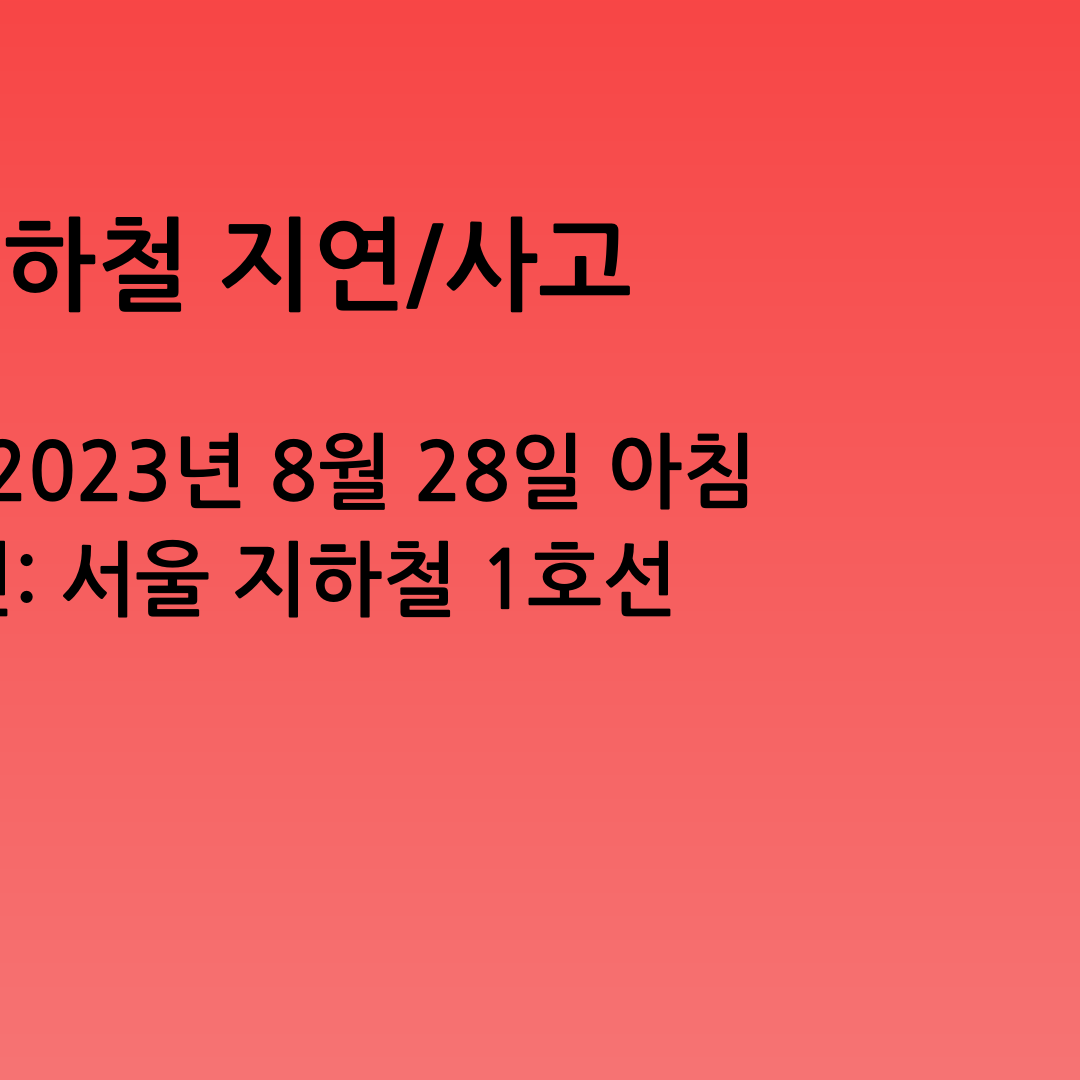

In [70]:
from PIL import Image, ImageDraw, ImageFont

# 이미지와 텍스트 관련 설정
width, height = 1080, 1080
image = Image.new("RGB", (width, height), "white")
draw = ImageDraw.Draw(image)

# 그라데이션 배경 설정
def apply_gradient():
    start_color = (248, 70, 70)
    end_color = (246, 116, 116)
    for y in range(height):
        r = start_color[0] + (end_color[0] - start_color[0]) * y // height
        g = start_color[1] + (end_color[1] - start_color[1]) * y // height
        b = start_color[2] + (end_color[2] - start_color[2]) * y // height
        draw.line([(0, y), (width, y)], fill=(r, g, b))

apply_gradient()

# 폰트 설정
font_path = "NanumGothicBold.otf" 
title_font = ImageFont.truetype(font_path, 100)
content_font = ImageFont.truetype(font_path, 80)

'''
# 텍스트 추가
def draw_text(x, y, text, font, fill="white"):
    text_width, text_height = draw.textbbox(text, font=font)
    draw.text((x - text_width / 2, y), text, font=font, fill=fill)
'''

# 텍스트 그리는 함수
def draw_text(x, y, text, font, fill="black"):
    # textbbox를 사용하여 텍스트 크기 측정
    text_width, text_height = draw.textbbox((x, y), text, font=font)[2:]
    # 텍스트 그리기, x 위치 조정
    draw.text((x - text_width / 2, y), text, font=font, fill=fill)

# 제목과 내용 텍스트 위치
draw_text(width / 2, height * 0.2, "지하철 지연/사고", title_font)
draw_text(width / 2, height * 0.4, f"일시: {incident_info['date']}", content_font)
draw_text(width / 2, height * 0.5, f"노선: {incident_info['line']}", content_font)


# 이미지 저장 및 보기
image.save("subway_incident_info.png")
image.show()
